PREDICTING WITH CONVOLUTIONAL NEURAL NETWORKS

---




### 1. Google Colab runtime setup [Optional]

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Clone and install spectrai package 
!git clone https://github.com/franckalbinet/spectrai.git 
!pip install /content/spectrai 

In [1]:
# Prepare /root folder content
!cp -r /content/drive/My\ Drive/Colab\ Notebooks/data/data_spectrai /root

In [2]:
# Create configuration file
!mkdir /root/.spectrai_config & cp /content/spectrai/config.toml /root/.spectrai_config

### 2. Import packages

In [ ]:
# To train on a GPU
!pip install tensorflow-gpu

In [7]:
from spectrai.datasets.kssl import (get_tax_orders_lookup_tbl, load_data)
from spectrai.vis.spectra import (plot_spectra)
from spectrai.metrics.keras import rpd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np

from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers, models, Model
import tensorflow.keras.backend as K
import tensorflow.keras.utils as utils

import matplotlib.pyplot as plt

### 3. Load KSSL dataset

In [8]:
# Loading Potassium, NH4OAc
X, X_names, y, y_names, instances_id = load_data([725])

In [9]:
print('X shape: ', X.shape)
print('X approx. memory size: {} MB'.format(X.nbytes // 10**6))
print('y approx. memory size: {} MB'.format(y.nbytes // 10**6))
print('Wavenumbers: ', X_names)
print('Target variable: ', y_names)

X shape:  (50714, 1764)
X approx. memory size: 357 MB
y approx. memory size: 1 MB
Wavenumbers:  [3999 3997 3995 ...  603  601  599]
Target variable:  ['lay_depth_to_top' 'order_id' 'calc_value']


### 4. Data preparation

In [10]:
# Keeping data with analyte concentration > 0 only
idx_y_valid = y[:, -1] > 0
X = X[idx_y_valid,:]
y = y[idx_y_valid,:]

# Note that we do not apply Savitsky-Golay derivation/filtering as it
# is assumed that such feature engineering is performed automaticlly by a CNN. 

# Scale data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [11]:
# Creating train, valid, test sets
X, X_test, y, y_test = train_test_split(X, y[:, -1], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

print('X test shape: ', X_test.shape)
print('X valid shape: ', X_valid.shape)
print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)

X test shape:  (9728, 1764)
X valid shape:  (7782, 1764)
X train shape:  (31126, 1764)
y train shape:  (31126,)


### 5. Defining CNN model

In [14]:
activation = 'relu'
input_dim = X_train.shape[1]

model = keras.models.Sequential()
model.add(layers.Reshape((input_dim, 1), input_shape=(input_dim,)))

model.add(layers.BatchNormalization())
model.add(layers.Conv1D(32, 30, activation=activation))
model.add(layers.MaxPool1D(4))

model.add(layers.BatchNormalization())
model.add(layers.Conv1D(64, 30, activation=activation))
model.add(layers.MaxPool1D(4))

model.add(layers.BatchNormalization())
model.add(layers.Conv1D(128, 30, activation=activation))
model.add(layers.MaxPool1D(4))

#model.add(layers.Dropout(rate=0.4))

model.add(layers.Flatten())

model.add(layers.BatchNormalization())
model.add(layers.Dense(100, activation=activation))

model.add(layers.BatchNormalization())
model.add(layers.Dense(50, activation=activation))

model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation=activation))

#model.add(layers.Dropout(rate=0.2))

model.add(layers.Dense(1,  activation='linear'))

model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='mse', metrics=[rpd])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1764, 1)           0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 1764, 1)           4         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1735, 32)          992       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 433, 32)           0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 433, 32)           128       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 404, 64)           61504     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 101, 64)          

### 6. Training the model

In [16]:
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-4)
history2 = model.fit(X_train, y_train, epochs=200, validation_data=(X_valid, y_valid))

Epoch 1/200
973/973 [==============================] - 11s 12ms/step - loss: 0.0562 - rpd: 4.2024 - val_loss: 0.2558 - val_rpd: 2.8597
Epoch 2/200
973/973 [==============================] - 11s 12ms/step - loss: 0.0547 - rpd: 4.2919 - val_loss: 0.2997 - val_rpd: 2.6946
Epoch 3/200
973/973 [==============================] - 11s 12ms/step - loss: 0.0558 - rpd: 4.2720 - val_loss: 0.2743 - val_rpd: 2.6635
Epoch 4/200
973/973 [==============================] - 11s 12ms/step - loss: 0.0566 - rpd: 4.2072 - val_loss: 0.2679 - val_rpd: 2.7204
Epoch 5/200
973/973 [==============================] - 11s 12ms/step - loss: 0.0541 - rpd: 4.2669 - val_loss: 0.2499 - val_rpd: 2.7438
Epoch 6/200
973/973 [==============================] - 11s 12ms/step - loss: 0.0532 - rpd: 4.2954 - val_loss: 0.2502 - val_rpd: 2.8252
Epoch 7/200
973/973 [==============================] - 11s 12ms/step - loss: 0.0569 - rpd: 4.2753 - val_loss: 0.2511 - val_rpd: 2.8176
Epoch 8/200
973/973 [==============================] - 

### 7. Assessing learning

In [17]:
# Concat all runs history
def concat_history(*args):
  all_history = args[0].history.copy()
  for hist in args[1:]:
    for k in all_history.keys():
      all_history[k] += hist.history[k]
  return all_history

all_history = concat_history(history, history2)

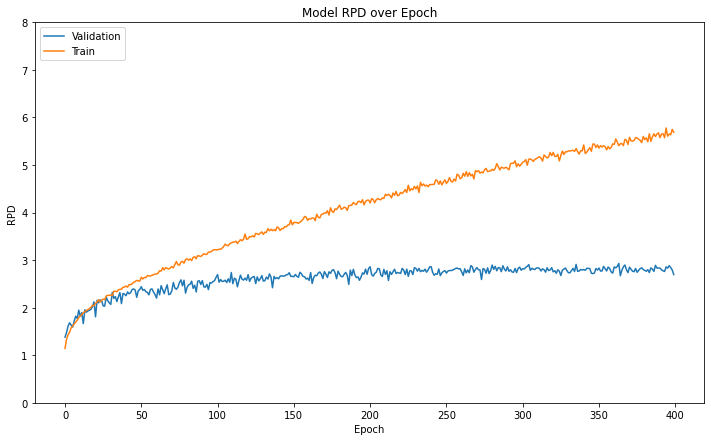

In [22]:
# Plot training & validation accuracy values
fig, ax = plt.subplots(figsize=(12,7))
_ = ax.plot(all_history['val_rpd'])
_ = ax.plot(all_history['rpd'])
plt.ylim(0, 8)
plt.title('Model RPD over Epoch')
plt.ylabel('RPD')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper left')

In [33]:
_, rpd = model.evaluate(X_test, y_test)
print('RPD on test set:', rpd)

304/304 [==============================] - 1s 3ms/step - loss: 0.2383 - rpd: 2.4606
RPD on test set: 2.4606411457061768


In [35]:
print('R2 on training set: ', r2_score(model.predict(X_test), y_test))

R2 on training set:  0.7859046731242388
